In [1]:
import mujoco
import os
import cv2
import mediapy as media
import numpy as np

In [3]:
def add_text_frame(texts, frame):
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    for i, t in enumerate(texts):
        cv2.putText(frame_bgr, t, (10, 30 + i * 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    return frame_rgb

In [4]:
def randomize_ball_position(mymodel, seed=None):
  if seed is not None:
    np.random.seed(seed)
  # Randomize the position of the ball
  radius = 0.36
  ball_pos_x = np.random.uniform(-radius, radius)
  ball_pos_y = float(np.random.choice([1, 1]) * np.sqrt(radius ** 2 - ball_pos_x ** 2))
  print('Original ball position:', mymodel.body_pos[mujoco.mj_name2id(mymodel, mujoco.mjtObj.mjOBJ_BODY, 'ball')])
  print('New ball position:', [ball_pos_x, ball_pos_y])
  mymodel.body_pos[mujoco.mj_name2id(mymodel, mujoco.mjtObj.mjOBJ_BODY, 'ball')][0] = ball_pos_x
  mymodel.body_pos[mujoco.mj_name2id(mymodel, mujoco.mjtObj.mjOBJ_BODY, 'ball')][1] = ball_pos_y

Original ball position: [0.2  0.3  0.95]
New ball position: [-0.011846689611303418, 0.359805024902729]


""

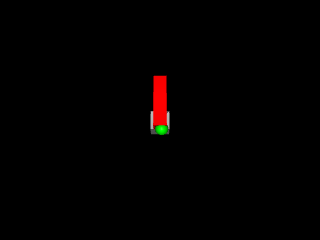

In [5]:
xml_path = "myrobot.xml"

# Read the XML content from the file
with open(xml_path, 'r') as file:
    my_robot_xml = file.read()
model = mujoco.MjModel.from_xml_string(my_robot_xml)
randomize_ball_position(model, seed=None)
data = mujoco.MjData(model)
height = 480
width = 640


with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera='my_camera')

  media.show_image(renderer.render())

# Simple 1 DOF arm with a ball
## Goal: reach the ball

### 1. Use PID controller

In [6]:
duration = 10 # seconds
timestep = 0.01 # seconds
fps = int(1 / timestep)
num_frames = int(duration * fps)

with open(xml_path, 'r') as file:
    my_robot_xml = file.read()
model = mujoco.MjModel.from_xml_string(my_robot_xml)
randomize_ball_position(model, seed=None)
data = mujoco.MjData(model)
height = 480
width = 640

observed_var_dict = {
    'time': np.zeros(num_frames),
    'qpos': np.zeros((num_frames, model.nv)), 
    'qvel': np.zeros((num_frames, model.nv)), 
    'ctrl': np.zeros((num_frames, model.nv)),
    }

def control_strategy(model, data, integral, previous_error, time):
    arm_tip_pos = data.geom_xpos[mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'arm_tip')]
    ball_pos = model.body_pos[mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'ball')]

    distance_euclid = np.linalg.norm(arm_tip_pos - ball_pos)
   
    # Calculate the error between the target position and the arm tip position
    assert arm_tip_pos.shape == ball_pos.shape == (3,)
    angle_ball = np.arctan2(ball_pos[1], ball_pos[0])
    angle_arm = np.arctan2(arm_tip_pos[1], arm_tip_pos[0])
    angle_diff = angle_ball - angle_arm
    error = angle_diff


    kp = 0.2
    ki= 0.000001
    kd = 0.2
    proportional_error = kp * error
    integral += error * time
    integral_error = ki * integral
    derivative = (error - previous_error) / timestep
    derivative_error = kd * derivative
    control_signal = proportional_error + integral_error + derivative_error
    control_signal = np.clip(control_signal, -0.1, 0.1)
    previous_error = error

    information = {'distance_euclid': distance_euclid, 'angle_diff': angle_diff,
                   'proportional_error': proportional_error, 'integral_error': integral_error,
                   'derivative_error': derivative_error,
                   'arm_tip_pos': arm_tip_pos, 'ball_pos': ball_pos}
    
    return control_signal, integral, previous_error, error, information


with mujoco.Renderer(model, height, width) as renderer:
    frames = []
    # Initialize PID controller variables
    integral = 0
    previous_error = 0


    for i in range(num_frames):
        time = i / fps
       
        control_signal, integral, previous_error, error, information = control_strategy(model, data, integral, previous_error, time)
        data.ctrl[0] = control_signal
        distance_euclid = information['distance_euclid']

        # Step the simulation
        mujoco.mj_step(model, data)

        observed_var_dict['time'][i] = data.time
        observed_var_dict['ctrl'][i] = data.ctrl[:]
        observed_var_dict['qpos'][i] = data.qpos[:]
        observed_var_dict['qvel'][i] = data.qvel[:]

        # Update the scene and render
        renderer.update_scene(data, camera='my_camera')
        frame = renderer.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)


        text_list = [
            f'Time: {data.time:.2f}',
            f'Control Signal: {control_signal:.2f}',
            f'Error: {error:.2f}',
            f'Distance Euclidean: {distance_euclid:.2f}',
            f'Angle Diff: {information["angle_diff"]:.2f}',
            f'qvel: {data.qvel[0]:.2f}',
            f'Arm Tip XYZ: {information["arm_tip_pos"][0]:.2f} {information["arm_tip_pos"][1]:.2f} {information["arm_tip_pos"][2]:.2f}',
            f'Ball XYZ: {information["ball_pos"][0]:.2f} {information["ball_pos"][1]:.2f} {information["ball_pos"][2]:.2f}'
        ]
        
        frames.append(add_text_frame(text_list, frame))

Original ball position: [0.2  0.3  0.95]
New ball position: [-0.35872840219719426, 0.030231332373020153]


In [7]:
# Display the rendered frames as a video
# media.show_video(frames, fps=fps)

### 2. Use RL to learn the control strategy

In [1]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [ ]:
import importlib
import arm_env

importlib.reload(arm_env)

# Create the custom environment
env = arm_env.ArmEnv(model_path='myrobot.xml')

# Check the environment
check_env(env)

load_existing_model = True


if load_existing_model:
    print("Loading existing model")
    model = PPO.load("ppo_arm", env=env)
else:
    print('Creating new model')
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1, 
        tensorboard_log="./ppo_logs/",
        learning_rate=1e-4,  # Default is fine, but try tuning
        n_steps=2**8,  # Collect more steps before updating policy
        batch_size=64,  # Mini-batch size for training
        n_epochs=10,  # More training passes per batch
        gamma=0.999,  # Discount factor
        gae_lambda=0.95,  # Smoother advantage estimation
        clip_range=0.2,  # Clipping parameter
        ent_coef=0.01,  # Encourages exploration
        vf_coef=0.5,  # Importance of value function loss
        max_grad_norm=0.5,  # Prevents exploding gradients
        policy_kwargs=dict(net_arch=[32, 64, 32])  # Small but effective policy network
    )

reward_logger = arm_env.RewardLoggerCallback(env, movie_save_freq=int(1e6), model_save_freq=int(1e5), verbose=1)

# Train the agent
model.learn(total_timesteps=int(3e7), callback=reward_logger, tb_log_name="PPO")


# Save the trained model
model.save("ppo_arm")



Loading existing model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_logs/PPO_9


-----------------------------
| time/              |      |
|    fps             | 1273 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 256  |
-----------------------------


In [27]:
model.save("ppo_arm")

NameError: name 'model' is not defined

In [3]:
import gc


del model
del env
del reward_logger
gc.collect()

745

0

In [ ]:
importlib.reload(arm_env)
# Load the trained model
load_model = PPO.load("ppo_arm")

# Test the trained model
frames = []
obs, _ = env.reset()
done = False
while not done:
    action, _states = load_model.predict(obs)
    obs, rewards, done, truncated, info = env.step(action)
    frame = env.render(mode='rgb_array')
    text_list = [
        f'done: {done}',
        f'reward: {rewards:.2f}',
    ]
    frames.append(add_text_frame(text_list, frame))
media.show_video(frames, fps=fps)